In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0  # Use EfficientNetV2B0, or any other variant like EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adamax


In [2]:
#VARIABLES FOR TESTING
#---------------------
imagesize = 224,224 #224,224 in final
fullimagesize = 224,224,3 #224,224,3 in final
#---------------------

#path to our cropped images
dataset_path = 'archive/crop/'

#splitting into training and validation
train_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    seed = 64,
    subset = 'training',
    image_size=(imagesize),  # Adjust the image size to 128 x 128 for faster processing
    batch_size=16,          # How many samples we want to load / batch
    shuffle=True            
)

valid_data = image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    seed = 23,
    subset = 'validation',
    image_size=(imagesize),
    batch_size=16,
    shuffle=True
)

# Split validation_data into validation & test set
val_batches = tf.data.experimental.cardinality(valid_data) # takes the number of batches within the validation data
test_data = valid_data.take(val_batches // 4) # takes the  
val_data = valid_data.skip(val_batches // 4)

class_names = train_data.class_names

Found 31917 files belonging to 74 classes.
Using 25534 files for training.
Found 31917 files belonging to 74 classes.
Using 6383 files for validation.


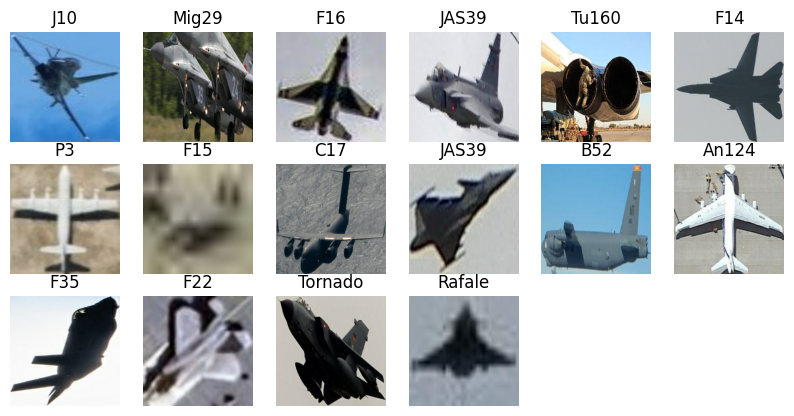

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(32, len(images))):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
# allows the model to load the next batch while the model is training on the current batch, increasing efficiency
pf_train = train_data.prefetch(buffer_size=AUTOTUNE)
pf_test = test_data.prefetch(buffer_size=AUTOTUNE)
pf_val = val_data.prefetch(buffer_size=AUTOTUNE)



In [4]:
import tensorflow as tf
from tensorflow.keras import layers

# Base model: EfficientNetV2B0, excluding the top (ImageNet-specific layers)
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(fullimagesize))  # Adjust input_shape as needed
base_model.trainable = False  # Freeze the base model layers

for layer in base_model.layers[-30:]:
    layer.trainable = True

# Max pooling layer replaces average pooling
global_max = layers.GlobalMaxPooling2D()

# Output layer
output_layer = layers.Dense(len(class_names), activation='softmax')

# Input layer
inputs = tf.keras.Input(shape=(fullimagesize))

# Preprocess the input
x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)

# Pass the input through the base model
x = base_model(x)

# Apply global max pooling after the base model
x = global_max(x)

# Batch normalization (optional, can be added here)
x = layers.BatchNormalization()(x)

# Output layer
outputs = output_layer(x)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary to verify
#model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 74)             │        94,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,019,226 (22.96 MB)

 Trainable params: 1,261,226 (4.81 MB)

 Non-trainable params: 4,758,000 (18.15 MB)

In [5]:
history = model.fit(pf_train, validation_data=(pf_val), epochs = 5)

Epoch 1/5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 349s 210ms/step - accuracy: 0.3939 - loss: 2.5807 - val_accuracy: 0.8331 - val_loss: 0.6249
Epoch 2/5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 317s 199ms/step - accuracy: 0.7631 - loss: 0.8626 - val_accuracy: 0.9077 - val_loss: 0.3542
Epoch 3/5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 343s 215ms/step - accuracy: 0.8451 - loss: 0.5467 - val_accuracy: 0.9219 - val_loss: 0.2954
Epoch 4/5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 321s 201ms/step - accuracy: 0.8825 - loss: 0.3925 - val_accuracy: 0.9373 - val_loss: 0.2480
Epoch 5/5
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 323s 203ms/step - accuracy: 0.9074 - loss: 0.3041 - val_accuracy: 0.9410 - val_loss: 0.2604


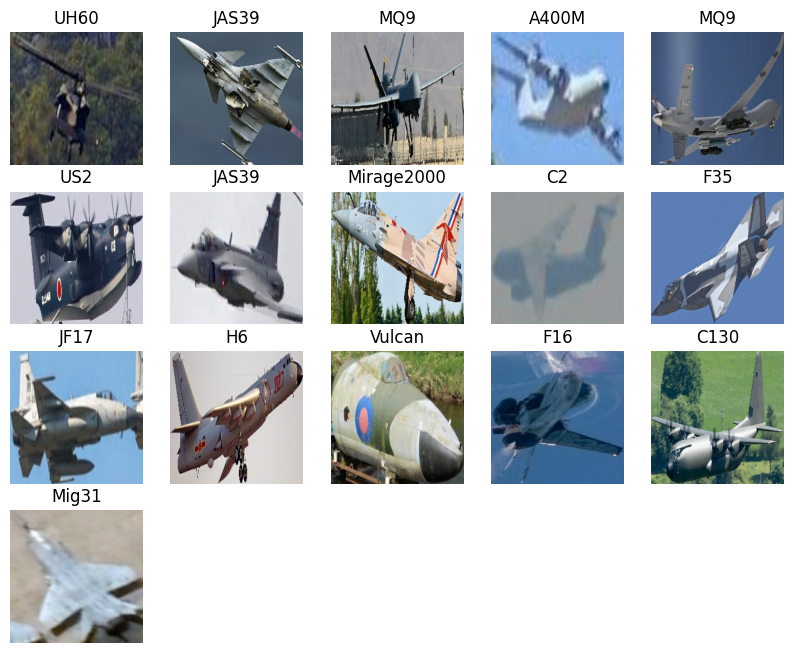

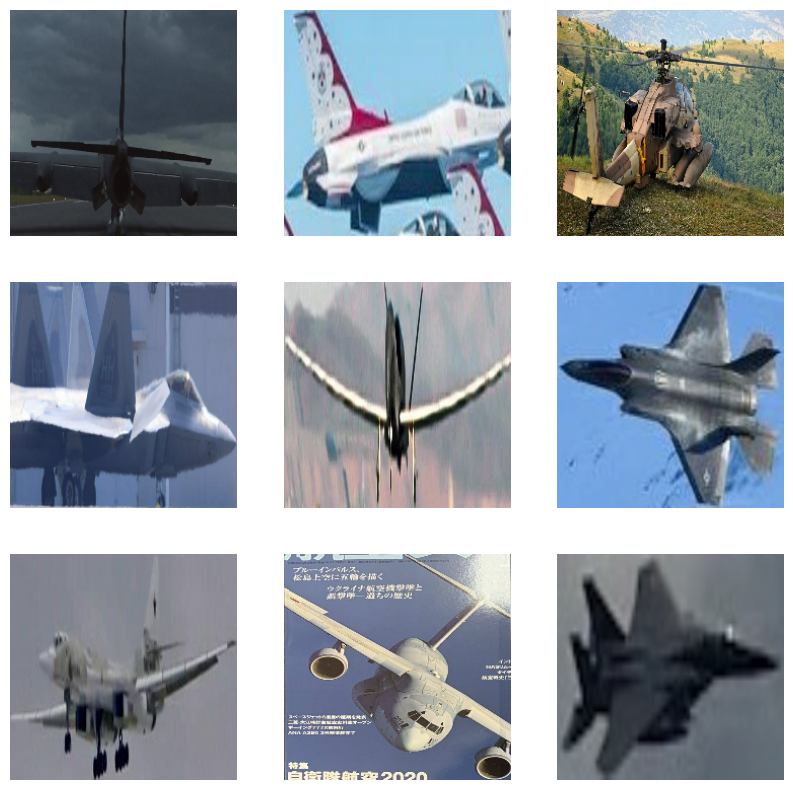

You must install pydot (`pip install pydot`) for `plot_model` to work.


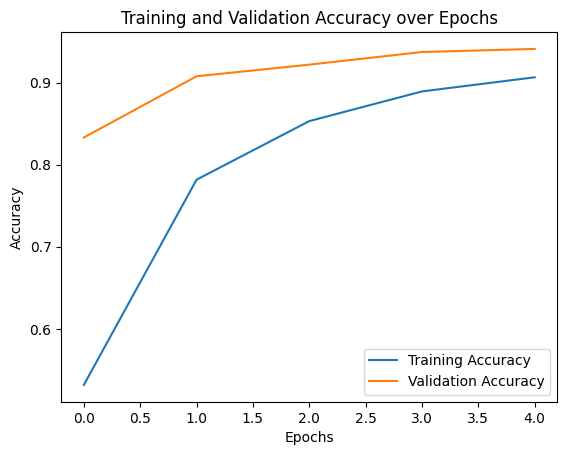

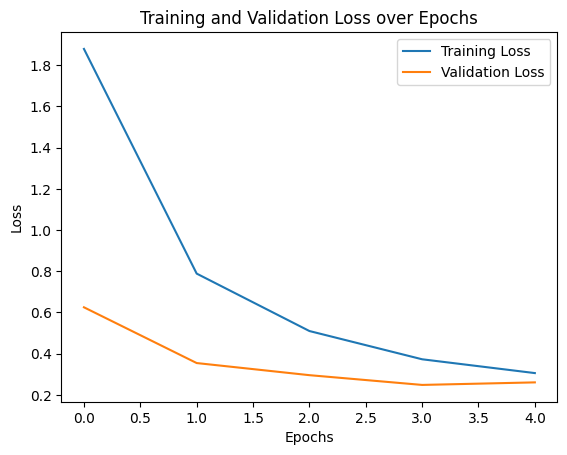

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(min(25, len(images))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

plt.figure(figsize=(10, 10))

# Take one batch from the training data
for images, _ in train_data.take(1):
    # Plot the first 9 images in a 3x3 grid
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the tensor to numpy for plotting
        plt.axis("off")  # Remove axis for better visualization

plt.show()  # Display the plot

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()